In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Tumor Marker
!ls

/content/gdrive/My Drive/Tumor Marker
brain-tumor			  nt1.jpg      test.jpg
masked_image.jpg		  nt.jpg       tumor_marker.h5
Mask_RCNN			  __pycache__  utils.py
mask_rcnn_coco.hdf5		  sample.jpg
mask_rcnn_tumor_detector_0015.h5  test111.png


In [0]:
## Path variables to change 
#model_path
#output image name "masked_image"

In [3]:
%tensorflow_version 1.x
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random
import keras

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils


############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p1 = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p1)
            ########################################################  
        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))        
    ax.figure.savefig("masked_image.jpg")       #this works
    #ax.imshow(masked_image)
    if auto_show:
    	plt.show()
      #plt.savefig('your_desired_path_to_image.jpg',bbox_inches='tight', pad_inches=-0.5,orientation= 'landscape') #############################################
      
    return masked_image

		#plt.close()
        
	
    #plt.savefig('new_image.jpg',bbox_inches='tight', pad_inches=-0.5,orientation= 'landscape') 
	#plt.close()    


def display_differences(image,
                        gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        class_names, title="", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=0.5, score_threshold=0.5):
    """Display ground truth and prediction instances on the same image."""
    # Match predictions to ground truth
    gt_match, pred_match, overlaps = utils.compute_matches(
        gt_box, gt_class_id, gt_mask,
        pred_box, pred_class_id, pred_score, pred_mask,
        iou_threshold=iou_threshold, score_threshold=score_threshold)
    # Ground truth = green. Predictions = red
    colors = [(0, 1, 0, .8)] * len(gt_match)\
           + [(1, 0, 0, 1)] * len(pred_match)
    # Concatenate GT and predictions
    class_ids = np.concatenate([gt_class_id, pred_class_id])
    scores = np.concatenate([np.zeros([len(gt_match)]), pred_score])
    boxes = np.concatenate([gt_box, pred_box])
    masks = np.concatenate([gt_mask, pred_mask], axis=-1)
    # Captions per instance show score/IoU
    captions = ["" for m in gt_match] + ["{:.2f} / {:.2f}".format(
        pred_score[i],
        (overlaps[i, int(pred_match[i])]
            if pred_match[i] > -1 else overlaps[i].max()))
            for i in range(len(pred_match))]
    # Set title if not provided
    title = title or "Ground Truth and Detections\n GT=green, pred=red, captions: score/IoU"
    # Display
    display_instances(
        image,
        boxes, masks, class_ids,
        class_names, scores, ax=ax,
        show_bbox=show_box, show_mask=show_mask,
        colors=colors, captions=captions,
        title=title)


def draw_rois(image, rois, refined_rois, mask, class_ids, class_names, limit=10):
    """
    anchors: [n, (y1, x1, y2, x2)] list of anchors in image coordinates.
    proposals: [n, 4] the same anchors but refined to fit objects better.
    """
    masked_image = image.copy()

    # Pick random anchors in case there are too many.
    ids = np.arange(rois.shape[0], dtype=np.int32)
    ids = np.random.choice(
        ids, limit, replace=False) if ids.shape[0] > limit else ids

    fig, ax = plt.subplots(1, figsize=(12, 12))
    if rois.shape[0] > limit:
        plt.title("Showing {} random ROIs out of {}".format(
            len(ids), rois.shape[0]))
    else:
        plt.title("{} ROIs".format(len(ids)))

    # Show area outside image boundaries.
    ax.set_ylim(image.shape[0] + 20, -20)
    ax.set_xlim(-50, image.shape[1] + 20)
    ax.axis('off')

    for i, id in enumerate(ids):
        color = np.random.rand(3)
        class_id = class_ids[id]
        # ROI
        y1, x1, y2, x2 = rois[id]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              edgecolor=color if class_id else "gray",
                              facecolor='none', linestyle="dashed")
        ax.add_patch(p)
        # Refined ROI
        if class_id:
            ry1, rx1, ry2, rx2 = refined_rois[id]
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal for easy visualization
            ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

            # Label
            label = class_names[class_id]
            ax.text(rx1, ry1 + 8, "{}".format(label),
                    color='w', size=11, backgroundcolor="none")

            # Mask
            m = utils.unmold_mask(mask[id], rois[id]
                                  [:4].astype(np.int32), image.shape)
            masked_image = apply_mask(masked_image, m, color)

    ax.imshow(masked_image)

    # Print stats
    print("Positive ROIs: ", class_ids[class_ids > 0].shape[0])
    print("Negative ROIs: ", class_ids[class_ids == 0].shape[0])
    print("Positive Ratio: {:.2f}".format(
        class_ids[class_ids > 0].shape[0] / class_ids.shape[0]))


# TODO: Replace with matplotlib equivalent?
def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image


def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")


def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)


def plot_overlaps(gt_class_ids, pred_class_ids, pred_scores,
                  overlaps, class_names, threshold=0.5):
    """Draw a grid showing how ground truth objects are classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs
    pred_scores: [N] float. The probability scores of predicted classes
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictions and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]

    plt.figure(figsize=(12, 10))
    plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(len(pred_class_ids)),
               ["{} ({:.2f})".format(class_names[int(id)], pred_scores[i])
                for i, id in enumerate(pred_class_ids)])
    plt.xticks(np.arange(len(gt_class_ids)),
               [class_names[int(id)] for id in gt_class_ids], rotation=90)

    thresh = overlaps.max() / 2.
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):
        text = ""
        if overlaps[i, j] > threshold:
            text = "match" if gt_class_ids[j] == pred_class_ids[i] else "wrong"
        color = ("white" if overlaps[i, j] > thresh
                 else "black" if overlaps[i, j] > 0
                 else "grey")
        plt.text(j, i, "{:.3f}\n{}".format(overlaps[i, j], text),
                 horizontalalignment="center", verticalalignment="center",
                 fontsize=9, color=color)

    plt.tight_layout()
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")


def draw_boxes(image, boxes=None, refined_boxes=None,
               masks=None, captions=None, visibilities=None,
               title="", ax=None):
    """Draw bounding boxes and segmentation masks with different
    customizations.

    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    masks: [N, height, width]
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominent each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    """
    # Number of boxes
    assert boxes is not None or refined_boxes is not None
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))

In [0]:
ROOT_DIR = os.path.abspath('Mask_RCNN/')
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib

In [6]:
class TumorConfig(Config):
    """Configuration for training on the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [7]:
MODEL_DIR = os.path.join(ROOT_DIR, 'log') # directory to save logs and trained model

model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir= "mask_rcnn_coco.hdf5"
)

model_path ="/content/gdrive/My Drive/Tumor Marker/mask_rcnn_tumor_detector_0015.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/gdrive/My Drive/Tumor Marker/mask_rcnn_tumor_detector_0015.h5


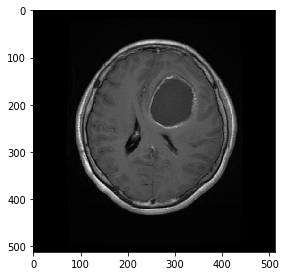

In [8]:
image = skimage.io.imread('nt1.jpg')
# original image
plt.figure(figsize=(4,4))
skimage.io.imshow(image)

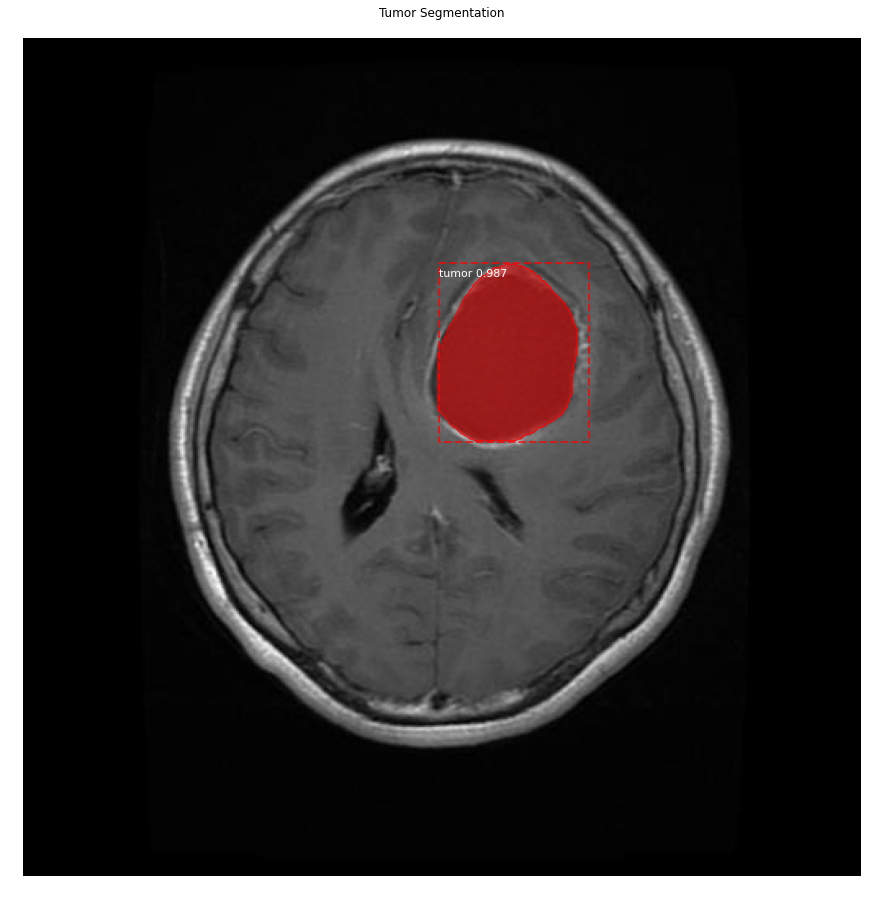

In [9]:
results = model.detect([image], verbose=0)
r = results[0]
class_names = ["predict", "tumor", "possibility"]
ax = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'],title ="Tumor Segmentation")